# Deep Learning on Genomics Data


- Some of the content from this notebook comes from a paper entitled, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou and others. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).


In this lab, we use deep learning to discover transcription-factor binding sites in DNA. You will design neural networks that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(The true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural networks you'll develop won't know this.)


## 1. Curate the Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

Sequences
1  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...

The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices!

To get each DNA sequence in the form of a matrix, we use _one-hot encoding_, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix. 

In the cell below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

Let's check that our work above to one-hot encode our DNA actually worked. 

In [0]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Extra notes - visualize the data
print('DNA Sequence #1:\n', sequences[0])
print('One hot encoding of Sequence #1:\n', input_features[0])

DNA Sequence #1:
 CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
One hot encoding of Sequence #1:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


Similarly, we can go ahead and load the labels. In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:

In [0]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [0]:
# Extra notes - visualize the data
print('Labels:', labels)
print('One hot encoding sequence of labels: ', input_labels)

Labels: [['0']
 ['0']
 ['0']
 ...
 ['0']
 ['1']
 ['1']]
One hot encoding sequence of labels:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [0]:
from sklearn.model_selection import train_test_split

# Create train-test split here

# train: 75%, test: 25%
X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.25, random_state=100)

## 2. Select the Architecture and Train

In the cell below, please construct a model using Keras. 

In [0]:
X_train[0]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# YOUR TURN: Fill in the following code. 
#            (You may have additional imports if you need them!)
def getModel():
  model=Sequential()
  model.add(Conv1D(
      filters=100,
      kernel_size=10,
      strides=1,
      padding='valid',
      input_shape=X_train[0].shape,
      activation='relu'
  ))
  model.add(MaxPooling1D(
      pool_size=15,
      strides=3,
      padding='same'
  ))
  model.add(Flatten())                      # makes everything into one vector
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))                   # used for regularization
  model.add(Dense(2, activation='sigmoid')) # 2 makes it a two-vector, a number
  return model

getModel()

In [0]:
#### DO NOT EDIT THIS
model = getModel() 

model.compile(loss='binary_crossentropy', optimizer='SGD', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 41, 100)           4100      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               179328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 183,686
Trainable params: 183,686
Non-trainable params: 0
________________________________________________

Now, we are ready to train the neural network you created above. Just to check that you understood (or now, that you have an opportunity to go _back_ and understand...) the data processing above, please fill in the parameters for the function below. 

In [0]:
## FILL IN THE MISSING PARAMETERS (do not change the return value, etc.)
history = model.fit(X_train, y_train,
                   epochs=50, verbose=0, validation_split=0.25) # validation_split: uses 25% as "testing" data

In [0]:
## DO NOT EDIT THIS
losses, validation_losses = history.history['loss'], history.history['val_loss']
accs, validation_accs = history.history['binary_accuracy'], history.history['val_binary_accuracy']
print('Losses: ', losses)
print('Validation Losses: ', validation_losses)

Losses:  [0.7096555233001709, 0.6842195987701416, 0.6728939414024353, 0.6514983773231506, 0.6376600861549377, 0.616280734539032, 0.5917752385139465, 0.5609560012817383, 0.5283524394035339, 0.49184873700141907, 0.44064486026763916, 0.40641602873802185, 0.3665050268173218, 0.3184615969657898, 0.2918570637702942, 0.2513689398765564, 0.23364827036857605, 0.21825650334358215, 0.18589283525943756, 0.17543800175189972, 0.1578543335199356, 0.15153217315673828, 0.13931944966316223, 0.12437961995601654, 0.12464581429958344, 0.11251168698072433, 0.10461066663265228, 0.09219948947429657, 0.0907527431845665, 0.08021081984043121, 0.08535771071910858, 0.08139513432979584, 0.0736294686794281, 0.07118665426969528, 0.06277437508106232, 0.06360182911157608, 0.06463077664375305, 0.05905760079622269, 0.05152030289173126, 0.052470624446868896, 0.05518947169184685, 0.04795873910188675, 0.04765438288450241, 0.04678328335285187, 0.03714264929294586, 0.04274368658661842, 0.042289476841688156, 0.0419363863766193

Create a function that accepts the per iteration training and validation loss (the first and second lines above), and outputs a well-labelled figure of their values versus iteration. 

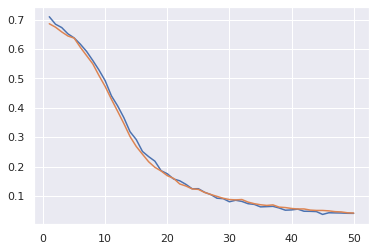

In [0]:
import matplotlib.pyplot as plt
## FILL IN THIS FUNCTION
def plotLosses(train_loss, validation_loss):
  epochs = np.arange(1, 51)
  plt.plot(epochs, train_loss)
  plt.plot(epochs, validation_loss)

# want train error to go down, validation error to diverge

## DO NOT CHANGE THIS
plotLosses(losses, validation_losses)

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Write a function to do this (with labels), as before!

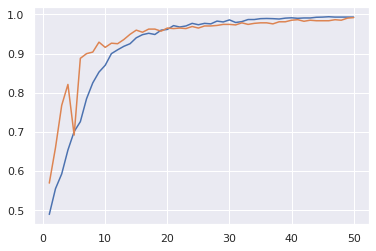

In [0]:
## FILL IN THIS FUNCTION
def plotAccuracy(train_acc, validation_acc):
  epochs = np.arange(1, 51)
  plt.plot(epochs, train_acc)
  plt.plot(epochs, validation_acc)
  
## DO NOT CHANGE THIS
plotAccuracy(accs, validation_accs)

## 3. Evaluate


The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

In [0]:
## YOU FILL IN THIS CODE
predicted_labels = model.predict(X_test, verbose=2)

16/16 - 0s


Now let's print a confusion matrix to see how we did!



Confusion matrix:
 [[252   0]
 [  1 247]]


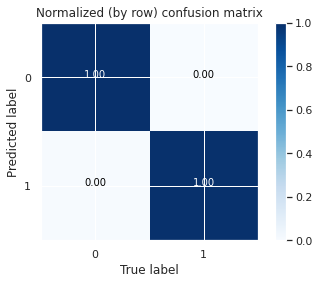

In [0]:
## YOU DO NOT EDITT THIS CODE
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized (by row) confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

**Write down two sentences here that explain what the confusion matrix above means.**

The confusion matrix shows the percentage of true positives, false positives, false negatives, and true negatives. My model gives 99% true positives and 100% true negatives.

## 4. Interpret ( You do not change this code. Please do read it, though)

Proceed past this point once your network is doing the right thing...

We now would like to understand a bit as to why  the neural network classifies a training point in the way that it does? To do so, we can compute a simple _saliency map_, which is the gradient of the model's prediction with respect to each individual nucleotide.  In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value.

In [0]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

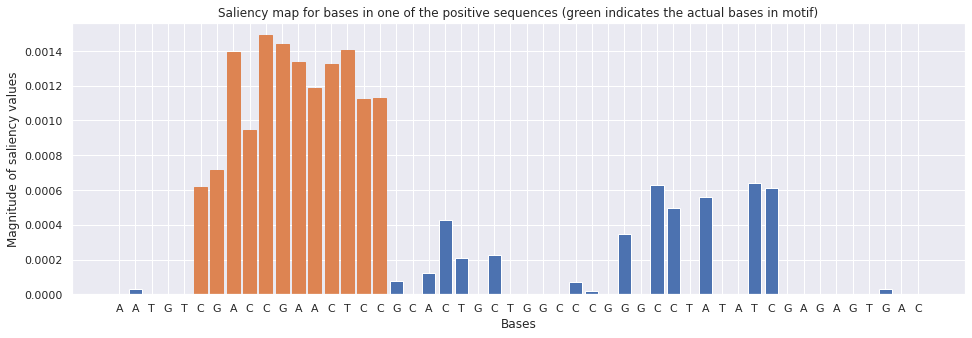

In [0]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

The results above should show high saliency values for the bases _CGACCGAACTCC_ appearing in the DNA sequence, if you did things correctly! Recall that this was the actual motif. Nice work!

The code below makes the same kinds of figures you saw last week. Note that these plots are basically showing the same thing!

In [0]:
#@title
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

def make_text(text, x, y, width, height, color, edgecolor,font=FontProperties(family='monospace')):
    tp = TextPath((0.0, 0.0), text, size=1, prop=font)
    bbox = tp.get_extents()
    bwidth = bbox.x1 - bbox.x0
    bheight = bbox.y1 - bbox.y0
    trafo = Affine2D()
    trafo.translate(-bbox.x0, -bbox.y0)
    trafo.scale(1 / bwidth * width, 1 / bheight * height)
    trafo.translate(x,y)
    tp = tp.transformed(trafo)
    return patches.PathPatch(tp, facecolor=color, edgecolor=edgecolor)

def plot_as_bars(ax, letters, heights, colors, width=0.8):
  letters, heights, N = list(letters), list(heights), len(letters)
  assert(N == len(heights));
  ax.set_ylim(min(0,min(heights)), max(0,max(heights)))
  ax.set_xlim(0, N)
  for idx, (letter, height, color) in enumerate(zip(letters, heights, colors)):
    txt = make_text(letter, x=idx+(1-width)/2, y=0, width=width, height=height, color=color, edgecolor=color)
    ax.add_patch(txt)

def plot_sequence_spectrum(ax, X, scores):
  decoding, colors = ["A", "C", "G", "T"], ['#008000', '#cc0000', '#0000cc', '#ffb300']
  seq = [np.array(decoding)[x] for x in np.apply_along_axis(np.argmax, 1, X)] # convert one hot -> {A, C, T, G}
  seq_scores = scores#np.apply_along_axis(lambda e: np.max(e) if abs(np.min(e)) < np.max(e) else np.min(e), 1, scores) # largest score by magnitude
  seq_colors = [np.array(colors)[x] for x in np.apply_along_axis(np.argmax, 1, X)] # convert one hot -> colors
  plot_as_bars(ax, seq, seq_scores, seq_colors) 

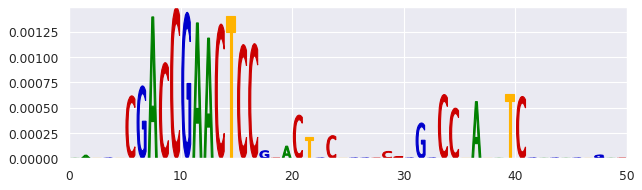

In [0]:
fig = plt.figure(figsize=(9, 2.5), dpi= 80)
ax = fig.add_subplot(111)
plot_sequence_spectrum(ax, input_features[sequence_index], sal)
plt.show()

## 5. Extension 1: Parameter sharing with reverse complement

We will now...

In [0]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
def getBetterModel():
  """
  Construct a model (do not compile or summarize it here) given 
  the task description above. 

  Note: not sure how to use this form of creating a model. learn more in class on sunday
  """
  shared_conv = Conv1D(filters=32, kernel_size=12)
  input_fwd = Input(shape=(train_features.shape[1], 4))
  conv_fwd = MaxPooling1D(pool_size=4)(shared_conv(input_fwd))
  input_rc = Input(shape=(train_features.shape[1], 4))
  conv_rc = MaxPooling1D(pool_size=4)(shared_conv(input_rc))
  merged_conv = concatenate([conv_fwd, conv_rc], axis=1) #make axis 1 to change pool_size
  merged_conv = Flatten()(merged_conv)
  output = Dense(16, activation='relu')(merged_conv)
  preds = Dense(2, activation='softmax')(output)
  m = Model(inputs=[input_fwd, input_rc], outputs=preds)
  return m

In [0]:
def makeReverseComplement(x): # Note: Ask what this does -- reverses the base pairing?
  x = x[::-1]
  rcMap = {'A':'T', 'G':'C', 'C':'G', 'T':'A'}
  return ''.join(rcMap[ch] for ch in x)

def getReverseComplementSequences(sequences):
  input_features_rc = []    
  for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(makeReverseComplement(sequence)))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features_rc.append(one_hot_encoded.toarray())
  return input_features_rc 

input_features_rc = getReverseComplementSequences(sequences)

In [0]:
#### DO NOT EDIT THIS
model2 = getBetterModel() 

model2.compile(loss='binary_crossentropy', optimizer='SGD', 
              metrics=['binary_accuracy'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 39, 32)       1568        input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_10 (MaxPooling1D) (None, 9, 32)        0           conv1d_6[0][0]             

In [0]:
# ask if this is used to show shape of data
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)
reverse_comp = makeReverseComplement(sequences[0])
print('DNA Sequence #1, reverse complement:\n',reverse_comp[:10],'...',reverse_comp[-10:])
print('One hot encoding of Sequence #1 (RC):\n',input_features_rc[0].T)


Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
DNA Sequence #1, reverse complement:
 GGTGTCCGCG ... TAGCCCTCGG
One hot encoding of Sequence #1 (RC):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)
train_features_rc, test_features_rc,_ ,_ = train_test_split(
    input_features_rc, input_labels, test_size=0.25, random_state=42)

# why are they called train_features, test_features instead of X_train, X_test

In [0]:
## FILL IN THE MISSING PARAMETERS (do not change the return value, etc.)
history2 = model.fit(train_features, train_labels,
                   epochs=50, verbose=0, validation_split=0.25)
data_train = [[train_features[i], train_features_rc[i]] for i in range(train_features.shape[0])]

# PLOT THE HISTORY

Confusion matrix:
 [[ 57 202]
 [ 52 189]]


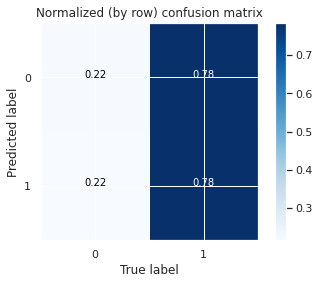

In [0]:
predicted_labels = model2.predict([np.array(np.stack(test_features)), np.array(np.stack(test_features_rc))])

## YOU DO NOT EDITT THIS CODE
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized (by row) confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [0]:
def compute_salient_bases2(model, x):
  input_tensors = [model.input[0], model.input[1]]
  gradients = model.optimizer.get_gradients(model.output[0][1],  [model.input[0], model.input[1]])
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  gradients = compute_gradients([np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

ValueError: ignored

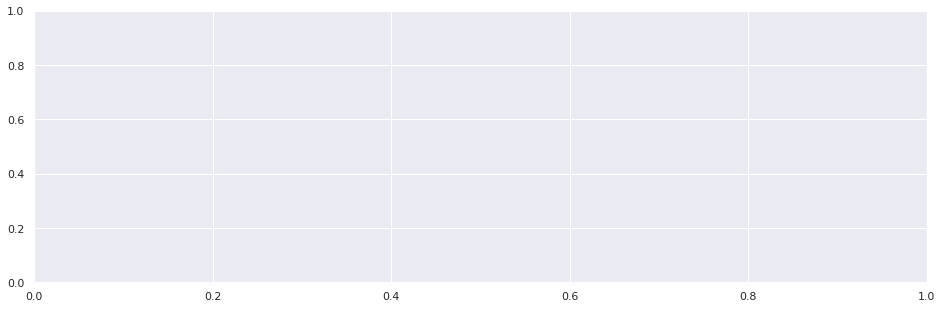

In [0]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases2(model2, [input_features[sequence_index], input_features_rc[sequence_index]])

# What is the point of this graph?

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');